# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
%matplotlib inline

import helper
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as pkl
import problem_unittests as tests
import tensorflow as tf
import warnings

from distutils.version import LooseVersion
from glob import glob
from matplotlib import pyplot

print('All imports successful, ready to rip!')

All imports successful, ready to rip!


In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

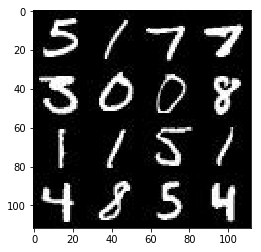

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

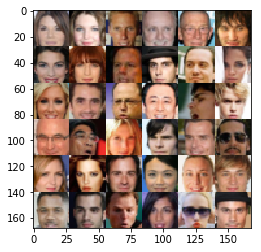

In [4]:
show_n_images = 40

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),  name = 'input_real')
    z = tf.placeholder(tf.float32, (None, z_dim),  name = 'input_z')
    lr = tf.placeholder(tf.float32, name = 'learning_rate_t')
    return image, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
D_NAME = 'discriminator'

def discriminator(images, reuse = False, alpha = .2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope(D_NAME, reuse = reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        # Training is always true because we are only interested in using the generator.
        # If need be, can set to false if we need to use this for inference
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flattened = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flattened, 1)
        activation_output = tf.sigmoid(logits)
        return activation_output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
G_NAME = 'generator'

def generator(z, out_channel_dim, is_train = True, alpha = .2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope(G_NAME, reuse = not is_train):
        x1 = tf.layers.dense(z, 2 * 2 * 512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(x1, training = is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 2x2x512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides = 2, padding = 'valid')
        bn2 = tf.layers.batch_normalization(x2, training = is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides = 2, padding = 'same')
        # 28x28xout_channel_dim
        output_activation = tf.tanh(logits)
        return output_activation


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha = .2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train = True)
    
    d_model_real, d_logits_real = discriminator(input_real, alpha = alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True, alpha = alpha)
    
    d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,
                                                          labels = tf.ones_like(d_model_real))
    d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                          labels = tf.zeros_like(d_model_fake))
    
    g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                     labels = tf.ones_like(d_model_fake))

    g_loss = tf.reduce_mean(g_loss)
    d_loss_real = tf.reduce_mean(d_loss_real)
    d_loss_fake = tf.reduce_mean(d_loss_fake)
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
  
    t_vars = tf.trainable_variables()
    d_vars = [tf_var for tf_var in t_vars if tf_var.name.startswith(D_NAME)]
    g_vars = [tf_var for tf_var in t_vars if tf_var.name.startswith(G_NAME)]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1)
        d_train_op = optimizer.minimize(d_loss, var_list = d_vars)
        g_train_op = optimizer.minimize(g_loss, var_list = g_vars)

        return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

def show_generator_output(sess, input_z, out_channel_dim, image_mode, example_z):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    :param example_z: A fixed, but random, set of inputs (rather than generating from scratch each time)
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    #z_dim = input_z.get_shape().as_list()[-1]
    #example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    return samples

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def model_inputs_from_shape(data_shape, z_dim):
                   # image_width, image_height, image_channels, z_dim
    return model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

def train(epoch_count, batch_size, z_dim, learning_rate, beta1,
          get_batches, data_shape, data_image_mode,
          print_every = 10, show_every = 100,
          num_images_to_sample = 18,
          train_discriminator_every_N_steps = 2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    out_channel_dim = data_shape[3]
    input_real, input_z, lr_tensor = model_inputs_from_shape(data_shape, z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_op, g_train_op = model_opt(d_loss, g_loss, lr_tensor, beta1)

    saver = tf.train.Saver()
    
    # We would prefer to use the same 'randomized' input so we can compare output over training time...
    sample_z = np.random.uniform(-1, 1, size=(num_images_to_sample, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2 # per https://discussions.udacity.com/t/need-help-with-final-project-discrimnator-loss-much-lower-than-the-generator-one/400443
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                if steps % train_discriminator_every_N_steps == 0: # original GAN paper mentioned certain number of times to train g vs d.
                    sess.run(d_train_op, feed_dict = {input_real: batch_images, input_z: batch_z, lr_tensor: learning_rate})
                sess.run(g_train_op, feed_dict = {input_real: batch_images, input_z: batch_z, lr_tensor: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print('Step {}, Epoch {}/{}'.format(steps, epoch_i + 1, epoch_count),
                          'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                          'Geneator Loss: {:.4f}'.format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    gen_samples = show_generator_output(sess, input_z,
                                          out_channel_dim, data_image_mode, sample_z)
                    samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')
    
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
        
    
    return losses, samples      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 10, Epoch 1/2 Discriminator Loss: 0.5945... Geneator Loss: 3.3582
Step 20, Epoch 1/2 Discriminator Loss: 0.1440... Geneator Loss: 4.4114
Step 30, Epoch 1/2 Discriminator Loss: 0.7189... Geneator Loss: 9.0710
Step 40, Epoch 1/2 Discriminator Loss: 0.2375... Geneator Loss: 3.0035
Step 50, Epoch 1/2 Discriminator Loss: 1.3685... Geneator Loss: 6.9880
Step 60, Epoch 1/2 Discriminator Loss: 0.6219... Geneator Loss: 1.2198
Step 70, Epoch 1/2 Discriminator Loss: 1.5629... Geneator Loss: 5.8495
Step 80, Epoch 1/2 Discriminator Loss: 0.5541... Geneator Loss: 2.4870
Step 90, Epoch 1/2 Discriminator Loss: 1.7649... Geneator Loss: 6.0091
Step 100, Epoch 1/2 Discriminator Loss: 0.6028... Geneator Loss: 2.8582


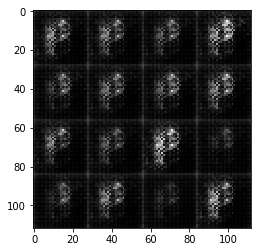

Step 110, Epoch 1/2 Discriminator Loss: 1.6046... Geneator Loss: 3.2445
Step 120, Epoch 1/2 Discriminator Loss: 1.1444... Geneator Loss: 1.9658
Step 130, Epoch 1/2 Discriminator Loss: 0.3394... Geneator Loss: 2.7002
Step 140, Epoch 1/2 Discriminator Loss: 0.4791... Geneator Loss: 2.1037
Step 150, Epoch 1/2 Discriminator Loss: 1.2828... Geneator Loss: 3.9194
Step 160, Epoch 1/2 Discriminator Loss: 0.2147... Geneator Loss: 2.5168
Step 170, Epoch 1/2 Discriminator Loss: 1.5459... Geneator Loss: 2.7696
Step 180, Epoch 1/2 Discriminator Loss: 0.3727... Geneator Loss: 2.4080
Step 190, Epoch 1/2 Discriminator Loss: 0.2260... Geneator Loss: 3.0704
Step 200, Epoch 1/2 Discriminator Loss: 0.1523... Geneator Loss: 3.4012


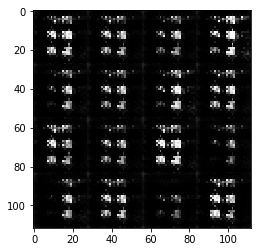

Step 210, Epoch 1/2 Discriminator Loss: 0.3573... Geneator Loss: 3.6331
Step 220, Epoch 1/2 Discriminator Loss: 0.5293... Geneator Loss: 1.9641
Step 230, Epoch 1/2 Discriminator Loss: 0.5144... Geneator Loss: 1.5179
Step 240, Epoch 1/2 Discriminator Loss: 0.2696... Geneator Loss: 3.7141
Step 250, Epoch 1/2 Discriminator Loss: 0.4831... Geneator Loss: 1.8294
Step 260, Epoch 1/2 Discriminator Loss: 0.6655... Geneator Loss: 1.6611
Step 270, Epoch 1/2 Discriminator Loss: 0.4319... Geneator Loss: 3.0676
Step 280, Epoch 1/2 Discriminator Loss: 0.3770... Geneator Loss: 2.5612
Step 290, Epoch 1/2 Discriminator Loss: 0.4888... Geneator Loss: 2.4727
Step 300, Epoch 1/2 Discriminator Loss: 0.9605... Geneator Loss: 1.8208


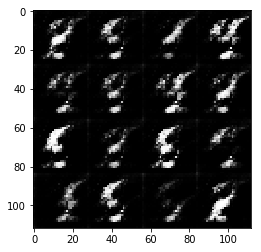

Step 310, Epoch 1/2 Discriminator Loss: 1.0217... Geneator Loss: 1.9135
Step 320, Epoch 1/2 Discriminator Loss: 0.5678... Geneator Loss: 2.1541
Step 330, Epoch 1/2 Discriminator Loss: 0.7401... Geneator Loss: 3.3608
Step 340, Epoch 1/2 Discriminator Loss: 0.3843... Geneator Loss: 3.9142
Step 350, Epoch 1/2 Discriminator Loss: 0.7947... Geneator Loss: 3.7716
Step 360, Epoch 1/2 Discriminator Loss: 1.0022... Geneator Loss: 1.6721
Step 370, Epoch 1/2 Discriminator Loss: 0.4870... Geneator Loss: 2.2785
Step 380, Epoch 1/2 Discriminator Loss: 0.6125... Geneator Loss: 2.8335
Step 390, Epoch 1/2 Discriminator Loss: 0.4535... Geneator Loss: 2.1577
Step 400, Epoch 1/2 Discriminator Loss: 0.6428... Geneator Loss: 2.0596


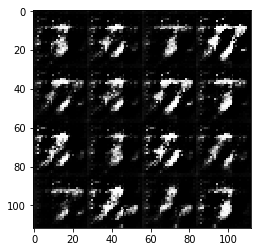

Step 410, Epoch 1/2 Discriminator Loss: 0.5671... Geneator Loss: 1.6112
Step 420, Epoch 1/2 Discriminator Loss: 1.3380... Geneator Loss: 1.3481
Step 430, Epoch 1/2 Discriminator Loss: 0.5858... Geneator Loss: 2.1581
Step 440, Epoch 1/2 Discriminator Loss: 0.8750... Geneator Loss: 1.9114
Step 450, Epoch 1/2 Discriminator Loss: 0.6048... Geneator Loss: 1.5208
Step 460, Epoch 1/2 Discriminator Loss: 0.5503... Geneator Loss: 2.1687
Step 470, Epoch 1/2 Discriminator Loss: 0.9588... Geneator Loss: 1.3247
Step 480, Epoch 1/2 Discriminator Loss: 0.7008... Geneator Loss: 2.7338
Step 490, Epoch 1/2 Discriminator Loss: 0.5637... Geneator Loss: 2.9834
Step 500, Epoch 1/2 Discriminator Loss: 1.4064... Geneator Loss: 2.1593


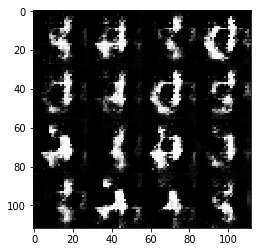

Step 510, Epoch 1/2 Discriminator Loss: 0.4791... Geneator Loss: 1.7421
Step 520, Epoch 1/2 Discriminator Loss: 0.8649... Geneator Loss: 1.3565
Step 530, Epoch 1/2 Discriminator Loss: 0.5647... Geneator Loss: 1.7663
Step 540, Epoch 1/2 Discriminator Loss: 0.5699... Geneator Loss: 2.3955
Step 550, Epoch 1/2 Discriminator Loss: 0.7964... Geneator Loss: 1.4457
Step 560, Epoch 1/2 Discriminator Loss: 0.5291... Geneator Loss: 2.0259
Step 570, Epoch 1/2 Discriminator Loss: 0.6834... Geneator Loss: 1.4424
Step 580, Epoch 1/2 Discriminator Loss: 0.8318... Geneator Loss: 2.0507
Step 590, Epoch 1/2 Discriminator Loss: 1.1133... Geneator Loss: 1.9558
Step 600, Epoch 1/2 Discriminator Loss: 0.9073... Geneator Loss: 1.2988


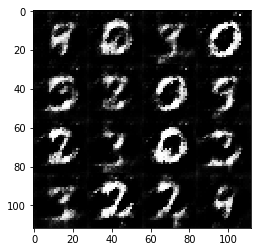

Step 610, Epoch 1/2 Discriminator Loss: 0.7501... Geneator Loss: 1.7220
Step 620, Epoch 1/2 Discriminator Loss: 0.6041... Geneator Loss: 1.6996
Step 630, Epoch 1/2 Discriminator Loss: 0.8503... Geneator Loss: 1.6040
Step 640, Epoch 1/2 Discriminator Loss: 0.8517... Geneator Loss: 2.2393
Step 650, Epoch 1/2 Discriminator Loss: 0.6804... Geneator Loss: 2.3727
Step 660, Epoch 1/2 Discriminator Loss: 0.8587... Geneator Loss: 1.5228
Step 670, Epoch 1/2 Discriminator Loss: 0.7310... Geneator Loss: 1.5999
Step 680, Epoch 1/2 Discriminator Loss: 0.6337... Geneator Loss: 2.1971
Step 690, Epoch 1/2 Discriminator Loss: 0.7447... Geneator Loss: 1.8861
Step 700, Epoch 1/2 Discriminator Loss: 0.5043... Geneator Loss: 1.9980


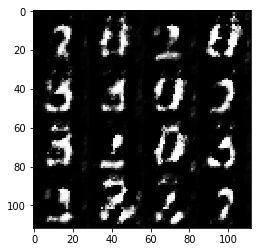

Step 710, Epoch 1/2 Discriminator Loss: 0.7607... Geneator Loss: 1.6459
Step 720, Epoch 1/2 Discriminator Loss: 0.6849... Geneator Loss: 1.3201
Step 730, Epoch 1/2 Discriminator Loss: 0.6433... Geneator Loss: 1.8095
Step 740, Epoch 1/2 Discriminator Loss: 1.0193... Geneator Loss: 0.9915
Step 750, Epoch 1/2 Discriminator Loss: 1.0723... Geneator Loss: 1.0711
Step 760, Epoch 1/2 Discriminator Loss: 0.5605... Geneator Loss: 1.8849
Step 770, Epoch 1/2 Discriminator Loss: 0.8640... Geneator Loss: 1.8005
Step 780, Epoch 1/2 Discriminator Loss: 0.8916... Geneator Loss: 1.9692
Step 790, Epoch 1/2 Discriminator Loss: 1.2921... Geneator Loss: 1.9158
Step 800, Epoch 1/2 Discriminator Loss: 0.8410... Geneator Loss: 1.4485


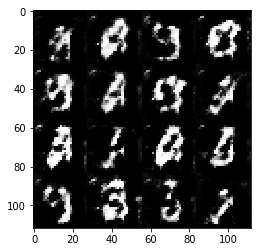

Step 810, Epoch 1/2 Discriminator Loss: 0.9953... Geneator Loss: 1.3307
Step 820, Epoch 1/2 Discriminator Loss: 0.9321... Geneator Loss: 1.2503
Step 830, Epoch 1/2 Discriminator Loss: 0.7721... Geneator Loss: 1.6789
Step 840, Epoch 1/2 Discriminator Loss: 1.0154... Geneator Loss: 1.3866
Step 850, Epoch 1/2 Discriminator Loss: 0.8633... Geneator Loss: 1.2356
Step 860, Epoch 1/2 Discriminator Loss: 1.1565... Geneator Loss: 0.9344
Step 870, Epoch 1/2 Discriminator Loss: 0.6816... Geneator Loss: 1.3503
Step 880, Epoch 1/2 Discriminator Loss: 1.0332... Geneator Loss: 0.9509
Step 890, Epoch 1/2 Discriminator Loss: 0.8512... Geneator Loss: 1.3540
Step 900, Epoch 1/2 Discriminator Loss: 0.9563... Geneator Loss: 1.3416


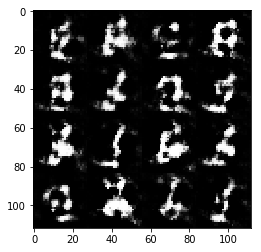

Step 910, Epoch 1/2 Discriminator Loss: 0.9793... Geneator Loss: 0.8946
Step 920, Epoch 1/2 Discriminator Loss: 0.8715... Geneator Loss: 1.7084
Step 930, Epoch 1/2 Discriminator Loss: 1.0057... Geneator Loss: 1.7958
Step 940, Epoch 2/2 Discriminator Loss: 1.0799... Geneator Loss: 0.9234
Step 950, Epoch 2/2 Discriminator Loss: 1.0050... Geneator Loss: 1.2886
Step 960, Epoch 2/2 Discriminator Loss: 0.8369... Geneator Loss: 1.2595
Step 970, Epoch 2/2 Discriminator Loss: 1.1844... Geneator Loss: 0.7535
Step 980, Epoch 2/2 Discriminator Loss: 0.6979... Geneator Loss: 1.7347
Step 990, Epoch 2/2 Discriminator Loss: 1.1740... Geneator Loss: 1.6915
Step 1000, Epoch 2/2 Discriminator Loss: 0.8910... Geneator Loss: 1.7866


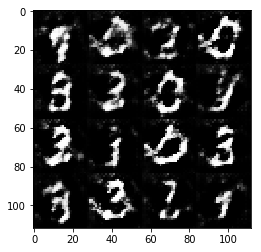

Step 1010, Epoch 2/2 Discriminator Loss: 1.0700... Geneator Loss: 1.9443
Step 1020, Epoch 2/2 Discriminator Loss: 0.9630... Geneator Loss: 1.2837
Step 1030, Epoch 2/2 Discriminator Loss: 0.9718... Geneator Loss: 1.1033
Step 1040, Epoch 2/2 Discriminator Loss: 0.9493... Geneator Loss: 1.3905
Step 1050, Epoch 2/2 Discriminator Loss: 1.2129... Geneator Loss: 0.6459
Step 1060, Epoch 2/2 Discriminator Loss: 1.0155... Geneator Loss: 1.4629
Step 1070, Epoch 2/2 Discriminator Loss: 0.9539... Geneator Loss: 1.7471
Step 1080, Epoch 2/2 Discriminator Loss: 1.0558... Geneator Loss: 0.8672
Step 1090, Epoch 2/2 Discriminator Loss: 0.9803... Geneator Loss: 0.9770
Step 1100, Epoch 2/2 Discriminator Loss: 0.9219... Geneator Loss: 1.3860


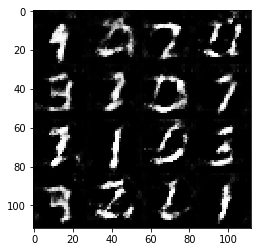

Step 1110, Epoch 2/2 Discriminator Loss: 0.8739... Geneator Loss: 1.6869
Step 1120, Epoch 2/2 Discriminator Loss: 0.9080... Geneator Loss: 1.5859
Step 1130, Epoch 2/2 Discriminator Loss: 0.8497... Geneator Loss: 1.6068
Step 1140, Epoch 2/2 Discriminator Loss: 0.9225... Geneator Loss: 1.5800
Step 1150, Epoch 2/2 Discriminator Loss: 1.0813... Geneator Loss: 0.5999
Step 1160, Epoch 2/2 Discriminator Loss: 1.1824... Geneator Loss: 0.6779
Step 1170, Epoch 2/2 Discriminator Loss: 0.8197... Geneator Loss: 1.1307
Step 1180, Epoch 2/2 Discriminator Loss: 0.9459... Geneator Loss: 1.5116
Step 1190, Epoch 2/2 Discriminator Loss: 0.8542... Geneator Loss: 1.1962
Step 1200, Epoch 2/2 Discriminator Loss: 0.9656... Geneator Loss: 0.7255


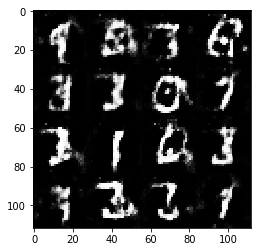

Step 1210, Epoch 2/2 Discriminator Loss: 0.8723... Geneator Loss: 0.9650
Step 1220, Epoch 2/2 Discriminator Loss: 1.0741... Geneator Loss: 1.5549
Step 1230, Epoch 2/2 Discriminator Loss: 1.1074... Geneator Loss: 1.4766
Step 1240, Epoch 2/2 Discriminator Loss: 0.8896... Geneator Loss: 1.1805
Step 1250, Epoch 2/2 Discriminator Loss: 0.9318... Geneator Loss: 1.5943
Step 1260, Epoch 2/2 Discriminator Loss: 0.9230... Geneator Loss: 0.8798
Step 1270, Epoch 2/2 Discriminator Loss: 0.8548... Geneator Loss: 0.9919
Step 1280, Epoch 2/2 Discriminator Loss: 0.9852... Geneator Loss: 1.4149
Step 1290, Epoch 2/2 Discriminator Loss: 1.0028... Geneator Loss: 0.9561
Step 1300, Epoch 2/2 Discriminator Loss: 0.9429... Geneator Loss: 1.0933


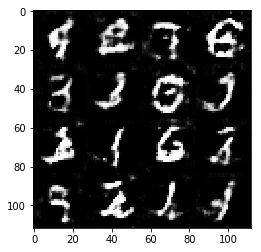

Step 1310, Epoch 2/2 Discriminator Loss: 0.8004... Geneator Loss: 1.4513
Step 1320, Epoch 2/2 Discriminator Loss: 0.8651... Geneator Loss: 0.8903
Step 1330, Epoch 2/2 Discriminator Loss: 1.0106... Geneator Loss: 1.5017
Step 1340, Epoch 2/2 Discriminator Loss: 1.0317... Geneator Loss: 0.6769
Step 1350, Epoch 2/2 Discriminator Loss: 1.0839... Geneator Loss: 1.6066
Step 1360, Epoch 2/2 Discriminator Loss: 0.9807... Geneator Loss: 1.5118
Step 1370, Epoch 2/2 Discriminator Loss: 1.0908... Geneator Loss: 1.6513
Step 1380, Epoch 2/2 Discriminator Loss: 0.9079... Geneator Loss: 1.2920
Step 1390, Epoch 2/2 Discriminator Loss: 0.9506... Geneator Loss: 1.3051
Step 1400, Epoch 2/2 Discriminator Loss: 1.1902... Geneator Loss: 0.4796


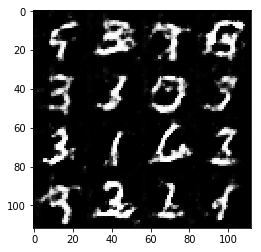

Step 1410, Epoch 2/2 Discriminator Loss: 0.9811... Geneator Loss: 1.1494
Step 1420, Epoch 2/2 Discriminator Loss: 1.0948... Geneator Loss: 1.1928
Step 1430, Epoch 2/2 Discriminator Loss: 1.0909... Geneator Loss: 1.2113
Step 1440, Epoch 2/2 Discriminator Loss: 0.8697... Geneator Loss: 1.0002
Step 1450, Epoch 2/2 Discriminator Loss: 1.1087... Geneator Loss: 1.8137
Step 1460, Epoch 2/2 Discriminator Loss: 1.1225... Geneator Loss: 0.7653
Step 1470, Epoch 2/2 Discriminator Loss: 0.9732... Geneator Loss: 1.3225
Step 1480, Epoch 2/2 Discriminator Loss: 0.9170... Geneator Loss: 1.0148
Step 1490, Epoch 2/2 Discriminator Loss: 1.3298... Geneator Loss: 1.5988
Step 1500, Epoch 2/2 Discriminator Loss: 1.2218... Geneator Loss: 0.5634


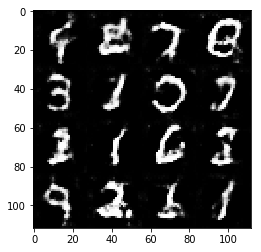

Step 1510, Epoch 2/2 Discriminator Loss: 1.0285... Geneator Loss: 1.5181
Step 1520, Epoch 2/2 Discriminator Loss: 1.1429... Geneator Loss: 0.6636
Step 1530, Epoch 2/2 Discriminator Loss: 1.0134... Geneator Loss: 0.8230
Step 1540, Epoch 2/2 Discriminator Loss: 1.1582... Geneator Loss: 1.2812
Step 1550, Epoch 2/2 Discriminator Loss: 0.9772... Geneator Loss: 0.9644
Step 1560, Epoch 2/2 Discriminator Loss: 1.1110... Geneator Loss: 1.2334
Step 1570, Epoch 2/2 Discriminator Loss: 0.9366... Geneator Loss: 1.2470
Step 1580, Epoch 2/2 Discriminator Loss: 0.8921... Geneator Loss: 1.1988
Step 1590, Epoch 2/2 Discriminator Loss: 1.0720... Geneator Loss: 1.4708
Step 1600, Epoch 2/2 Discriminator Loss: 1.0533... Geneator Loss: 0.8422


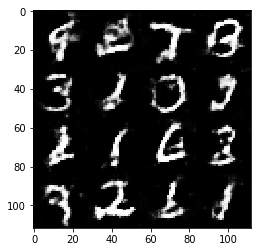

Step 1610, Epoch 2/2 Discriminator Loss: 1.3140... Geneator Loss: 0.4741
Step 1620, Epoch 2/2 Discriminator Loss: 1.0417... Geneator Loss: 1.2114
Step 1630, Epoch 2/2 Discriminator Loss: 1.1299... Geneator Loss: 0.6466
Step 1640, Epoch 2/2 Discriminator Loss: 1.1529... Geneator Loss: 0.7998
Step 1650, Epoch 2/2 Discriminator Loss: 1.0654... Geneator Loss: 1.0849
Step 1660, Epoch 2/2 Discriminator Loss: 1.0777... Geneator Loss: 1.1763
Step 1670, Epoch 2/2 Discriminator Loss: 1.0615... Geneator Loss: 1.1998
Step 1680, Epoch 2/2 Discriminator Loss: 1.0095... Geneator Loss: 0.9785
Step 1690, Epoch 2/2 Discriminator Loss: 1.0423... Geneator Loss: 0.9764
Step 1700, Epoch 2/2 Discriminator Loss: 1.0826... Geneator Loss: 1.5685


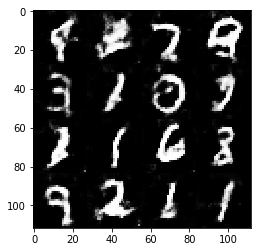

Step 1710, Epoch 2/2 Discriminator Loss: 1.0179... Geneator Loss: 1.0884
Step 1720, Epoch 2/2 Discriminator Loss: 1.1838... Geneator Loss: 1.2865
Step 1730, Epoch 2/2 Discriminator Loss: 1.0220... Geneator Loss: 0.7941
Step 1740, Epoch 2/2 Discriminator Loss: 0.9812... Geneator Loss: 0.9090
Step 1750, Epoch 2/2 Discriminator Loss: 1.3382... Geneator Loss: 2.0779
Step 1760, Epoch 2/2 Discriminator Loss: 1.1828... Geneator Loss: 0.7240
Step 1770, Epoch 2/2 Discriminator Loss: 1.0701... Geneator Loss: 0.9993
Step 1780, Epoch 2/2 Discriminator Loss: 1.1251... Geneator Loss: 0.6940
Step 1790, Epoch 2/2 Discriminator Loss: 1.0397... Geneator Loss: 1.0348
Step 1800, Epoch 2/2 Discriminator Loss: 1.0150... Geneator Loss: 1.4195


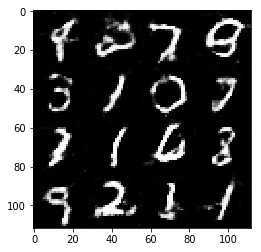

Step 1810, Epoch 2/2 Discriminator Loss: 1.1095... Geneator Loss: 0.6094
Step 1820, Epoch 2/2 Discriminator Loss: 1.0911... Geneator Loss: 1.2708
Step 1830, Epoch 2/2 Discriminator Loss: 1.0548... Geneator Loss: 0.9522
Step 1840, Epoch 2/2 Discriminator Loss: 1.1961... Geneator Loss: 0.6014
Step 1850, Epoch 2/2 Discriminator Loss: 1.2653... Geneator Loss: 0.5021
Step 1860, Epoch 2/2 Discriminator Loss: 1.0890... Geneator Loss: 1.1005
Step 1870, Epoch 2/2 Discriminator Loss: 0.9734... Geneator Loss: 0.8220
all done!


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

losses = []
samples = []
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1,
                            mnist_dataset.get_batches,
                            mnist_dataset.shape, mnist_dataset.image_mode)
    
print('all done!')

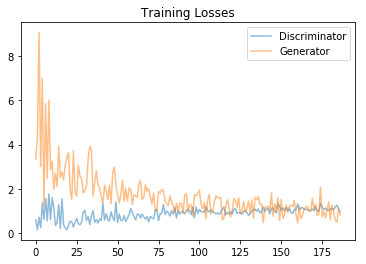

In [25]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 10, Epoch 1/1 Discriminator Loss: 0.3878... Geneator Loss: 6.0057
Step 20, Epoch 1/1 Discriminator Loss: 0.0898... Geneator Loss: 4.9703
Step 30, Epoch 1/1 Discriminator Loss: 0.0501... Geneator Loss: 7.5792
Step 40, Epoch 1/1 Discriminator Loss: 0.0372... Geneator Loss: 11.0629
Step 50, Epoch 1/1 Discriminator Loss: 0.1556... Geneator Loss: 2.0762
Step 60, Epoch 1/1 Discriminator Loss: 0.0540... Geneator Loss: 11.0174
Step 70, Epoch 1/1 Discriminator Loss: 0.0481... Geneator Loss: 4.1833
Step 80, Epoch 1/1 Discriminator Loss: 0.0265... Geneator Loss: 5.0606
Step 90, Epoch 1/1 Discriminator Loss: 0.0238... Geneator Loss: 5.6508
Step 100, Epoch 1/1 Discriminator Loss: 0.0110... Geneator Loss: 5.0276


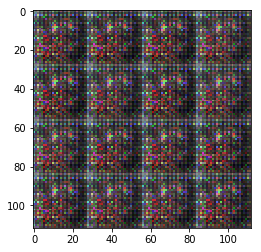

Step 110, Epoch 1/1 Discriminator Loss: 0.0258... Geneator Loss: 4.5893
Step 120, Epoch 1/1 Discriminator Loss: 0.0073... Geneator Loss: 6.0931
Step 130, Epoch 1/1 Discriminator Loss: 0.0107... Geneator Loss: 5.5614
Step 140, Epoch 1/1 Discriminator Loss: 0.0112... Geneator Loss: 5.1736
Step 150, Epoch 1/1 Discriminator Loss: 0.0052... Geneator Loss: 6.4578
Step 160, Epoch 1/1 Discriminator Loss: 0.0067... Geneator Loss: 5.7184
Step 170, Epoch 1/1 Discriminator Loss: 0.0050... Geneator Loss: 5.7565
Step 180, Epoch 1/1 Discriminator Loss: 0.0043... Geneator Loss: 6.7325
Step 190, Epoch 1/1 Discriminator Loss: 0.0037... Geneator Loss: 5.8995
Step 200, Epoch 1/1 Discriminator Loss: 0.0079... Geneator Loss: 5.7584


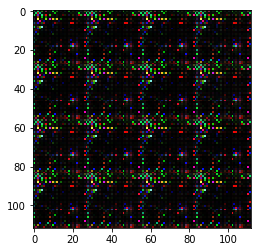

Step 210, Epoch 1/1 Discriminator Loss: 0.0046... Geneator Loss: 6.2911


KeyboardInterrupt: 

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = .5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

print('all done!')

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.